# PDF Seasonal cycle

This is a notebook in which we plot the seasonal cycle of the PDF in a 2D plot. The code is the same for all the different regions described in [Regions](./Distribution-regions.ipynb). The ARMOR-3D dataset is used in the years 2005-2018 period. As an example, only the plots for the Labrador and Irminger Seas region are shown. The parameters that change for each of the regions are also included as commented lines in the code.


This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   
   [2. Dictionaries used](#2.-Dictionaries-used)
   
   [3. Functions](#3.-Functions)
   
   [4. Example plot](#4.-Example-plot)
   
   
Figures of this kind can be found in the written report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf
), in the spatio-temporal description of the MLD in each region. At Section (3.3.3), (4.3.3), (5.3.3) and Chapter 6. kajkjdhfkjahdkjfahsdkj

## 1. Imported modules

In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

## 3. Functions

In [3]:
def Hist_params(data_set, n_bins):
    """
        Hist_param is a function that generates an histogram for each time step
        of a DataArray.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    
    heigth = np.empty(n_bins)
    
    for i in range(len(data_set.week)):
        data = data_set[i].values
        data = np.reshape(data, (data.shape[0]* data.shape[1]), order='F')
        data = data[~np.isnan(data)]
        
        hist, bins = np.histogram(data, bins=n_bins, range=(mn, mx), normed=False)
        heigth = np.vstack((heigth, hist))
        ## Just checking the number of grid points agrees
        #print(data.size, hist.sum())
        
    h = np.delete(heigth, 0, 0)
    
    return(h)
    

def PDF_time(fig, ax, data_set, mini, maxi, n_bins, *limits):
    """
        PDF_time is a function that generates a 2D plot from histograms
        and time steps. This is the plot will have as 'x' axis values of MLD
        classes in meters, and the 'y' axis will have time dimensions. The 
        colors indicate the number of grid points in each MLD class.
        
        Parameters:
        ------------
        fig : identifier to the figure
            Is the figure in which we look to plot the histograms
            
        ax : instance for the figure
            Identifies the position and coordinates that the plot 
            will be located
            
        data_set : DataArray
            Is the dataset we are working on
            
        mini : float
            minimum value to create the 'y' axis
            
        maxi : float
            maximum value to create the 'y' axis
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        limits : float (tuple)
            Lower and upper limits for the color bar
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    
    x = data_set.week
    y = np.arange(mini, maxi, abs((mini-maxi)/n_bins))
    X, Y = np.meshgrid(x, y)

    hist = Hist_params(data_set, n_bins)
    
    ## Minimum and maximum values for the color bar
    vmin = hist.min()
    vmax = hist.max()

    cs = ax.contourf(X, Y, np.log10(hist.T), 
                     np.linspace(np.log10(1.), np.log10(limits[1]), 11), 
                     cmap='viridis', extend='max')
    
    cb = fig.colorbar(cs, ax=ax, orientation='vertical')
    cb.set_label('log$_{10}$ N')
    
    
    

def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)



## Function to crop the dataset
def Crops(coord, data_set, dic):
    """Crops is a function that takes a data set and crops it into a 
    smaller region, using as parameters the values given by the dictionary. 
        
    Parameters:
    ------------
    coord : string
        Key value that identifies the region to obtain.

    data_set : DataArray
        Dataset to be cropped.

    dic : dictionary
        Dictionary with the boundaries of the regions.

    Output:
    -------
    new_ds : DataArray
        New data array corresponding to the region stated by 'coord'.
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    name_fig = dic[coord]['name']
    
    new_ds = data_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)

## 4. Example plot

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'
dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
## Adding time stamps for the dataset

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [6]:
## List with abbreviations of the month names
## to use in the time axis of the plot

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

### 4.1 Making the seasonal PDF

### Labrador and Irminger seas

In [7]:
## Croping the region from the complete dataset
## also masking to get only deep ocean values

coord = 'lab'
data1 = Crops(coord, c_armor1, reg_ext)
data15 = Crops(coord, c_armor15, reg_ext)
data15= Masking(data15, data15.to[0,25])

In [8]:
## Parameters for the histograms:
## number of bins, min&max values
## and title of the figure and saving name

## Number of bins for the histogam
## Limits for the colorbar: max upper limits is the lon*lat

n_bins = 100     #This always integer
clims = (0., 3500.)


## Gulf Stream
if coord == 'gul':
    mn = 9.
    mx = 250.
    f_t = 'Gulf Stream'
    save_name = 'Gul-PDF-Seasonal.png'
## Labrador and Irminger
elif coord == 'lab':
    mn = 9.
    mx = 900.
    f_t = 'Labrador and Irminger Seas'
    save_name = 'Lab-PDF-Seasonal.png'    
## North East Atlantic
elif coord == 'noe':
    mn = 9.
    mx = 500.
    f_t = 'North East Atlantic'
    save_name = 'Noe-PDF-Seasonal.png'
## Nordic Seas
elif coord == 'nor':
    mn = 9.
    mx = 750.
    f_t = 'Nordic Seas'
    save_name = 'Nor-PDF-Seasonal.png'
else :
  print('ERROR bins undefined for this region:', coord)

In [9]:
## Name of figure: title
fig_title = 'Histogram seasonal cycle of the MLD\n' + f_t

## Variables to plot
values = data1.where(data15.mask==1).groupby('time.week').mean(dim='time')

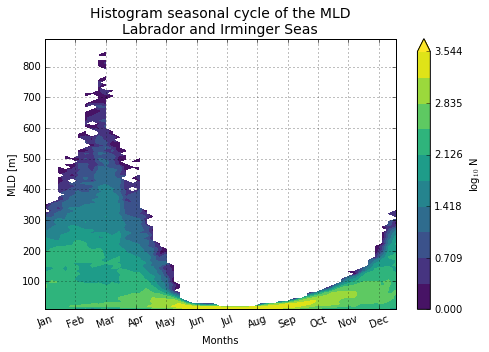

In [10]:
## Plotting

#%matplotlib notebook

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

PDF_time(fig, ax, values.mlotst, mn, mx, n_bins, *clims)

plt.xlabel('Months')
plt.ylabel('MLD [m]')
plt.title(fig_title, fontsize=14)

## Changing the x-axis:: time -> month-name, using the list
plt.xticks(np.arange(1, values.week.size, step=4.5), months, rotation=20)

plt.tight_layout()
plt.grid()
#plt.savefig(dir_o + save_name, bbox_inches='tight')
plt.show()